## SPAM DETECTION

L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.

Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.

Il CTO nello specifico ti fornisce un dataset e ti chiede di:

1. Addestrare un classificatore per identificare SPAM

2. Individuare i Topic principali tra le email SPAM presenti nel dataset

3. Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.

4. Estrarre dalle mail NON SPAM le Organizzazioni presenti.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

C:\Users\Gcarl\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## 1 Addestrare un classificatore per identificare SPAM

### Import dataset

In [2]:
URL = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/"

In [3]:
dataset_original = pd.read_csv(URL+"spam_dataset.csv")
dataset_original

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [4]:
dataset = dataset_original.drop(["Unnamed: 0", "label_num" ], axis=1)
dataset

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\nthis deal is to ...
...,...,...
5166,ham,Subject: put the 10 on the ft\nthe transport v...
5167,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...
5168,ham,Subject: calpine daily gas nomination\n>\n>\nj...
5169,ham,Subject: industrial worksheets for august 2000...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   object
 1   text    5171 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


In [6]:
dataset.isna().sum()

label    0
text     0
dtype: int64

##### Descriptive analysis

In [7]:
# set the theme and size of the charts
plt.rcParams["figure.figsize"] = (16,10)
sns.set_theme(palette="dark")

C:\Users\Gcarl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

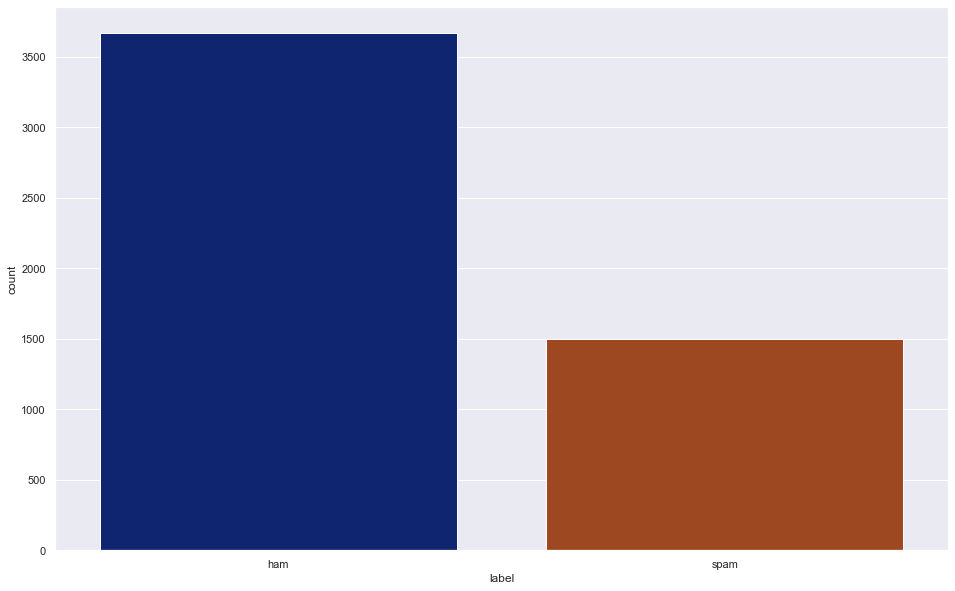

In [8]:
sns.countplot(dataset['label'],data=dataset)

In [9]:
counts = dataset["label"].value_counts()
print(f"ham = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%)")
print(f"spam = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%)")

ham = 3672 (71.01%)
spam = 1499 (28.99%)


##### Data cleaning function

In [10]:
import string
import spacy
import nltk
from nltk.corpus import stopwords
import re

english_stopwords = stopwords.words('english')
english_stopwords.extend(['subject']) # rimuovi la parola 'Subject' insieme alle altre stopwords
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    
    return sentence

#### Data cleaning

In [11]:
X = dataset["text"]
X.shape

(5171,)

In [12]:
y = dataset["label"]
y.shape

(5171,)

In [13]:
X_cleaned = []
for text in X:
    X_cleaned.append(data_cleaner(text))

In [14]:
X_cleaned

['enron methanol meter  follow note I give monday    preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economics purpose',
 'hpl nom january   see attached file hplnol  xls hplnol  xls',
 'neon retreat ho ho ho around wonderful time year neon leader retreat time I know time year extremely hectic tough think anything past holiday life go past week december  january  I like think minute calender I hand beginning fall semester retreat schedule weekend january   youth minister conference brad dustin connect week go change date follow weekend january   come part need think I think agree important get together time recharge battery get far spring semester lot trouble difficult get away without kid etc brad come potential alternative get together weekend let I know prefer first option would retreat similar past several year year could go heartland country inn www com outside brenham nice place  bedro

##### Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=.4, random_state=2)

##### Vectorize text

In [16]:
vec = CountVectorizer()

X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [17]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
X_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3102, 31633)
(2069, 31633)
(3102,)
(2069,)


#### Functions to evaluate models

In [20]:
def plot_confusion_matrix(y_true, y_pred, labels=["ham", "spam"], show_precision_recall=False):

    cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp 

    df_cm = pd.DataFrame(cm, index = labels, 
                        columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    sns.heatmap(df_cm, annot=True, fmt="g")

    if show_precision_recall:
    # Quale percentuale di classificazione spam sono effettivamente spam?
        plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
    # Quale percentuale di osservazioni spam sono state classificate come spam?
        plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")

### Model training - Logistic Regression 

In [21]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

##### Model evaluation

In [22]:
lr.score(X_test, y_test)

0.9772837119381343

In [23]:
# Train df
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
# Test df
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

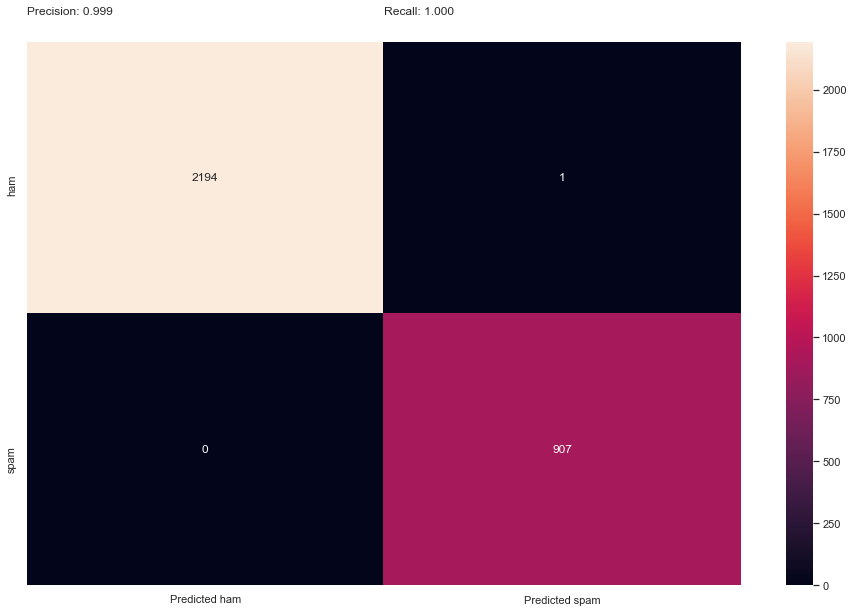

In [24]:
# Train confusion matrix
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

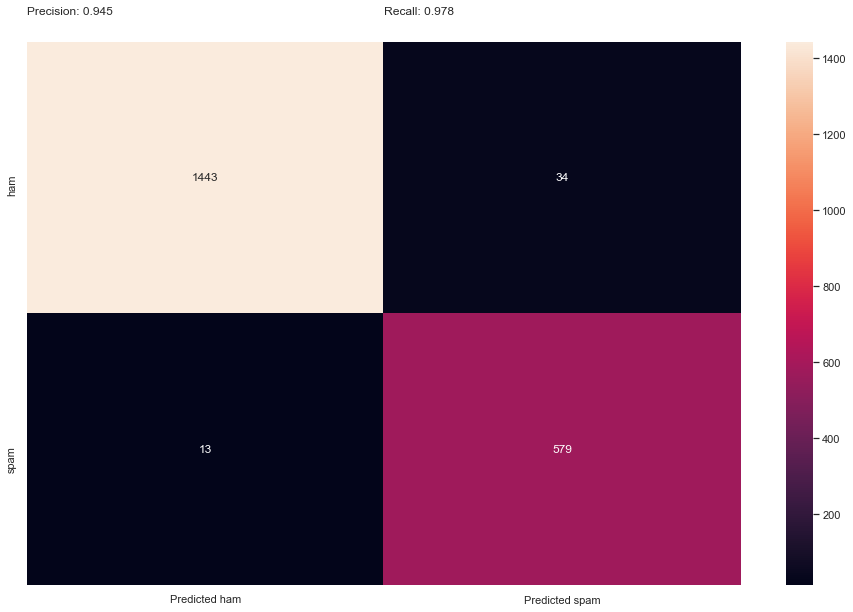

In [25]:
# Test confusion matrix
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

### Model training - Logistic Regression with class_weight = balanced

In [26]:
lr_bal = LogisticRegression(class_weight= "balanced")

lr_bal.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

##### Model evaluation

In [27]:
lr_bal.score(X_test, y_test)

0.9758337361043983

In [28]:
# Train df
y_pred_train = lr_bal.predict(X_train)
y_proba_train = lr_bal.predict_proba(X_train)
# Test df
y_pred_test = lr_bal.predict(X_test)
y_proba_test =  lr_bal.predict_proba(X_test)

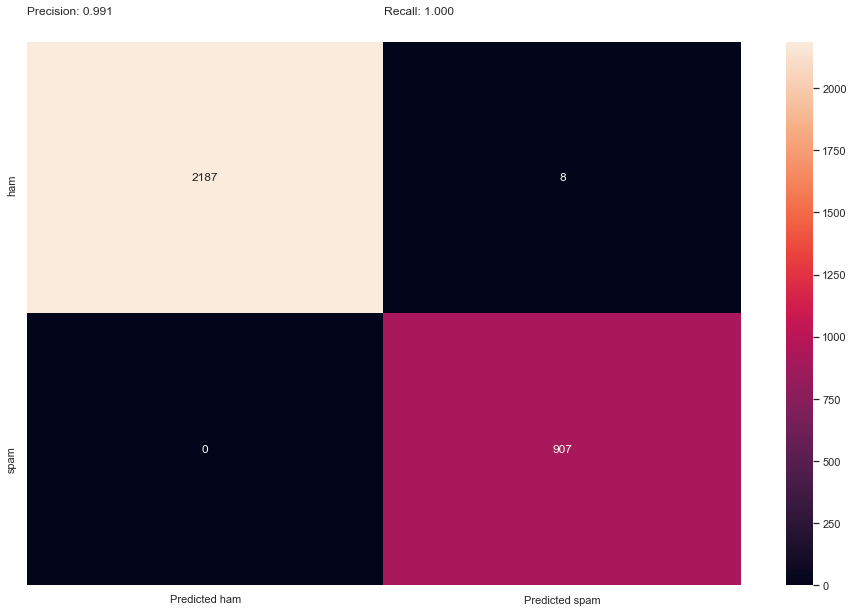

In [29]:
# Train confusion matrix
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

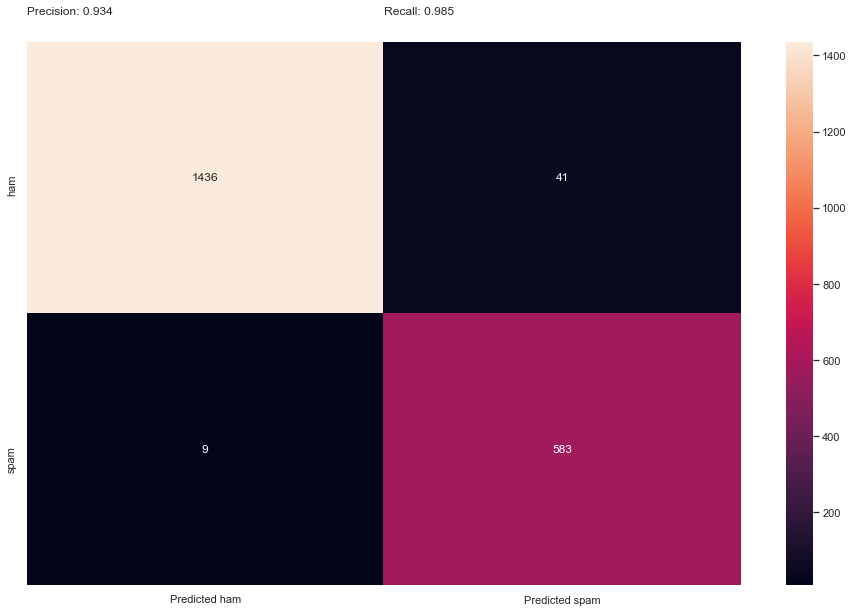

In [30]:
# Test confusion matrix
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

### Model training - Naive Bayes 

In [31]:
model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB()

##### Model evaluation

In [32]:
model.score(X_test, y_test)

0.9777670372160464

In [33]:
# Train df
y_pred_train = model.predict(X_train)
y_proba_train = model.predict_proba(X_train)
# Test df
y_pred_test = model.predict(X_test)
y_proba_test =  model.predict_proba(X_test)

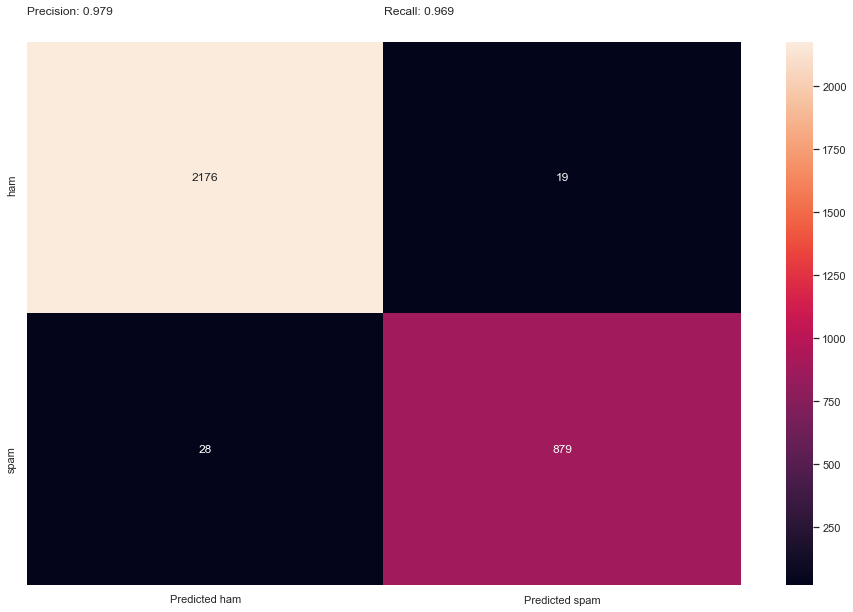

In [34]:
# Train confusion matrix
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

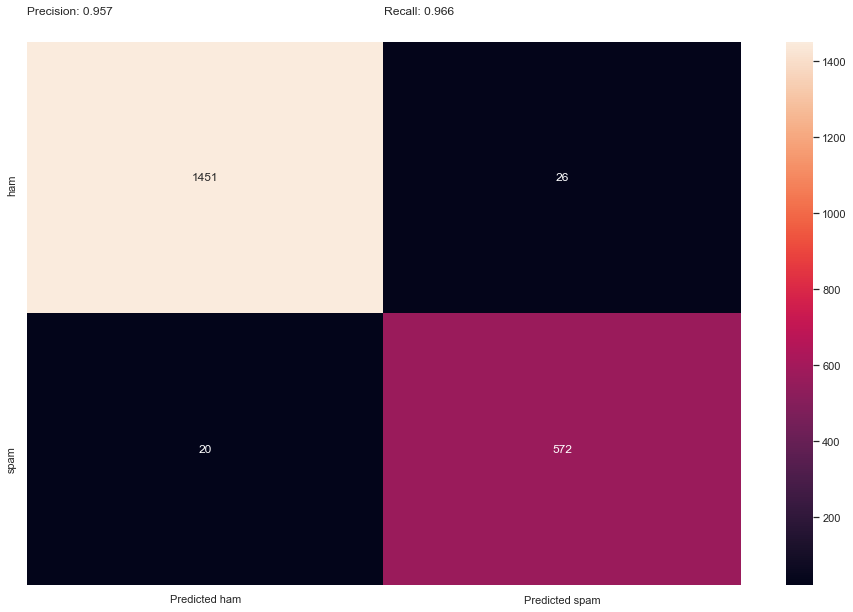

In [35]:
# Test confusion matrix
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

### Model training - MLPClassifier

In [36]:
clf = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(100,),
                    max_iter=100,
                    solver='adam',
                    tol=0.005,
                    verbose=True)

clf.fit(X_train,y_train)

Iteration 1, loss = 0.49567430
Iteration 2, loss = 0.32473085
Iteration 3, loss = 0.24041906
Iteration 4, loss = 0.18401168
Iteration 5, loss = 0.14398266
Iteration 6, loss = 0.11537097
Iteration 7, loss = 0.09487254
Iteration 8, loss = 0.07897955
Iteration 9, loss = 0.06723746
Iteration 10, loss = 0.05811955
Iteration 11, loss = 0.05090640
Iteration 12, loss = 0.04490804
Iteration 13, loss = 0.04016850
Iteration 14, loss = 0.03618870
Iteration 15, loss = 0.03279687
Iteration 16, loss = 0.02987278
Iteration 17, loss = 0.02740239
Iteration 18, loss = 0.02528640
Iteration 19, loss = 0.02343605
Iteration 20, loss = 0.02178233
Iteration 21, loss = 0.02031689
Iteration 22, loss = 0.01904465
Iteration 23, loss = 0.01786281
Training loss did not improve more than tol=0.005000 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='logistic', max_iter=100, tol=0.005, verbose=True)

##### Model evaluation

In [37]:
clf.score(X_test, y_test)

0.9855002416626389

In [38]:
# Train df
y_pred_train = clf.predict(X_train)
y_proba_train = clf.predict_proba(X_train)
# Test df
y_pred_test = clf.predict(X_test)
y_proba_test =  clf.predict_proba(X_test)

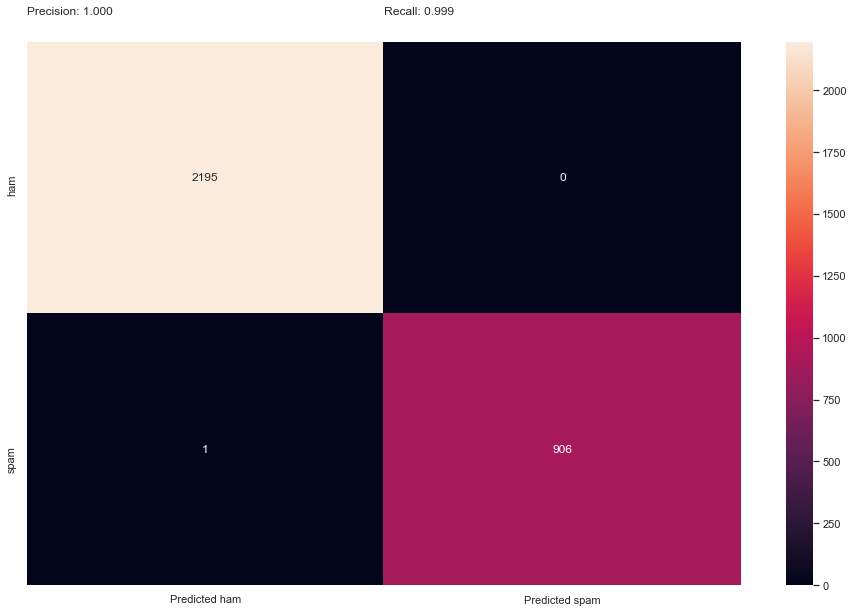

In [39]:
# Train confusion matrix
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

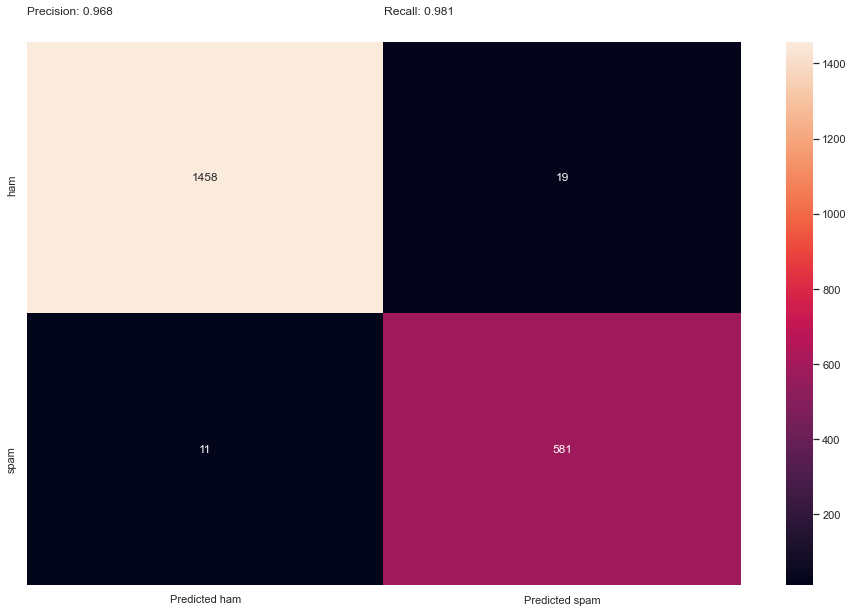

In [40]:
# Test confusion matrix
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

## 2 Individuare i Topic principali tra le email SPAM presenti nel dataset

### Dataset (only spam)

In [41]:
l = ["spam",]

dataset_spam = dataset_original[dataset_original["label"].isin(l)]
dataset_spam.drop(["Unnamed: 0", "label_num" ], axis=1, inplace=True)

dataset_spam

C:\Users\Gcarl\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,label,text
3,spam,"Subject: photoshop , windows , office . cheap ..."
7,spam,Subject: looking for medication ? we ` re the ...
10,spam,Subject: vocable % rnd - word asceticism\nvcsc...
11,spam,Subject: report 01405 !\nwffur attion brom est...
13,spam,Subject: vic . odin n ^ ow\nberne hotbox carna...
...,...,...
5159,spam,Subject: pictures\nstreamlined denizen ajar ch...
5161,spam,Subject: penny stocks are about timing\nnomad ...
5162,spam,Subject: anomaly boys from 3881\nuosda apaprov...
5164,spam,Subject: slutty milf wants to meet you\ntake t...


In [42]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel

In [43]:
text_spam = dataset_spam["text"]

#### Data cleaning function

In [44]:
def sent_to_words(items):
    for i in items:
        yield(gensim.utils.simple_preprocess(str(i), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in words if word not in english_stopwords and len(word) >=5] for words in texts]

### Data Cleaning

In [45]:
data_words = list(sent_to_words(text_spam))
data_words = remove_stopwords(data_words)

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Vectorize text
corpus = [id2word.doc2bow(text) for text in data_words]

### Model training - LDA

In [47]:
num_topics = 3 # best num for Coherence Score

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes = 2,
                                       random_state=25)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"height" + 0.005*"width" + 0.005*"pills" + 0.004*"price" + '
  '0.004*"company" + 0.003*"border" + 0.003*"align" + 0.003*"windows" + '
  '0.003*"software" + 0.003*"adobe"'),
 (1,
  '0.004*"please" + 0.004*"email" + 0.003*"click" + 0.003*"message" + '
  '0.003*"computron" + 0.003*"color" + 0.003*"online" + 0.003*"information" + '
  '0.003*"prices" + 0.002*"contact"'),
 (2,
  '0.008*"company" + 0.005*"statements" + 0.005*"information" + 0.003*"please" '
  '+ 0.003*"email" + 0.003*"investment" + 0.003*"report" + 0.003*"stock" + '
  '0.003*"within" + 0.003*"securities"')]


#### Salvare le nuvole dei topic su txt

In [48]:
for t in lda_model.print_topics():
    with open ("topic_file.txt", "a+", encoding = "utf8") as topic_file:
        t = str(t)+"\n"
        topic_rec = topic_file.write(t)

#### Importare da topic_file.txt i vari topic

In [49]:
with open("topic_file.txt", "r+", encoding = "utf8") as topic_file:
                topic_rec = topic_file.readlines()
        
emp_list = topic_rec

# Assegnazione delle nuvole di parole ai topic 
t_1 = emp_list[0]
t_2 = emp_list[1]
t_3 = emp_list[-1]

In [50]:
print(t_1)
print(t_2)
print(t_3)

(0, '0.006*"height" + 0.005*"width" + 0.005*"pills" + 0.004*"price" + 0.004*"company" + 0.003*"border" + 0.003*"align" + 0.003*"windows" + 0.003*"software" + 0.003*"adobe"')

(1, '0.004*"please" + 0.004*"email" + 0.003*"click" + 0.003*"message" + 0.003*"computron" + 0.003*"color" + 0.003*"online" + 0.003*"information" + 0.003*"prices" + 0.002*"contact"')

(2, '0.008*"company" + 0.005*"statements" + 0.005*"information" + 0.003*"please" + 0.003*"email" + 0.003*"investment" + 0.003*"report" + 0.003*"stock" + 0.003*"within" + 0.003*"securities"')



#### Topic cleaning

In [51]:
topic_words_cleaned = list(sent_to_words(emp_list))
topic_words_cleaned = remove_stopwords(topic_words_cleaned)

In [52]:
print(topic_words_cleaned[0])
print(topic_words_cleaned[1])
print(topic_words_cleaned[2])

['height', 'width', 'pills', 'price', 'company', 'border', 'align', 'windows', 'software', 'adobe']
['please', 'email', 'click', 'message', 'computron', 'color', 'online', 'information', 'prices', 'contact']
['company', 'statements', 'information', 'please', 'email', 'investment', 'report', 'stock', 'within', 'securities']


In [53]:
# Perplexity
print('Perplexity:', lda_model.log_perplexity(corpus))

# Coherence Score
cm_lda = CoherenceModel(model=lda_model,
                        dictionary=id2word,
                        corpus=corpus,
                       coherence="u_mass")

cm_lda = cm_lda.get_coherence() 
print('Coherence Score: ', cm_lda)

Perplexity: -9.366993711052153
Coherence Score:  -2.502328337345682


#### Function to find the best "num_topics"

In [54]:
def best_coherence_values(dictionary, corpus, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,                                          
                                           passes = 2, 
                                           random_state=25)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        corpus=corpus, 
                                        dictionary=dictionary, 
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
model_list, coherence_values = best_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,  
                                                        start=1, limit=15, step=1)

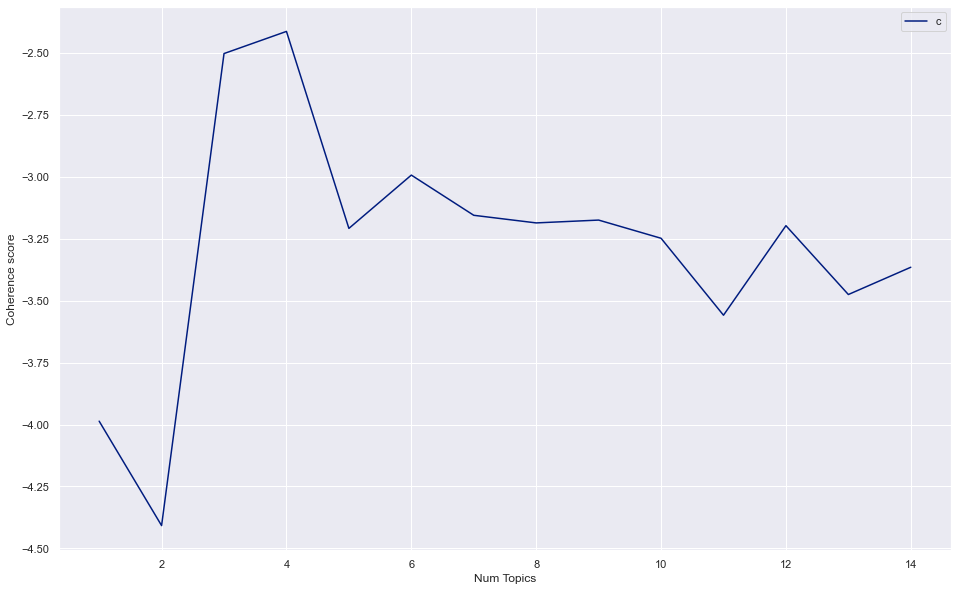

In [56]:
# Plot
limit=15; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 1  has Coherence Value of -3.986
Num Topics = 2  has Coherence Value of -4.408
Num Topics = 3  has Coherence Value of -2.502
Num Topics = 4  has Coherence Value of -2.413
Num Topics = 5  has Coherence Value of -3.208
Num Topics = 6  has Coherence Value of -2.993
Num Topics = 7  has Coherence Value of -3.155
Num Topics = 8  has Coherence Value of -3.186
Num Topics = 9  has Coherence Value of -3.175
Num Topics = 10  has Coherence Value of -3.248
Num Topics = 11  has Coherence Value of -3.559
Num Topics = 12  has Coherence Value of -3.197
Num Topics = 13  has Coherence Value of -3.475
Num Topics = 14  has Coherence Value of -3.365


## 3 Calcolare la distanza semantica tra i topic ottenuti, per dedurne l'eterogeneità.

In [58]:
from gensim.models import Word2Vec
import gensim.downloader
from scipy import spatial

In [59]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

##### Function for avg vector

In [60]:
def avg_vector(sentence):
    to_remove = 0
    vector = np.zeros(300)
    for word in sentence:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word)
        else:
            to_remove += 1
    if len(sentence) == to_remove:
        return np.zeros(300)
        
    return vector/(len(sentence)-to_remove)

#### Cosine Similarity tra le nuvole di parole dei topic

In [61]:
topic_list_vect = []
for topic in topic_words_cleaned:
    topic_list_vect.append(avg_vector(topic))

topic_list_vect

[array([-1.04530201e-01,  1.26368034e-02,  3.26361988e-02, -2.55744600e-01,
        -2.65569303e-01,  4.69956089e-02, -1.10285078e-01,  1.78168701e-01,
         6.97305009e-02, -1.08294780e+00, -1.55623595e-01,  2.84491798e-01,
        -5.57927094e-02, -8.01743980e-02,  6.58297978e-02,  1.55125699e-01,
        -2.30771013e-02,  6.88516978e-02, -3.87623005e-02, -2.47436996e-01,
         1.45756902e-01,  1.10939927e-03,  6.41772021e-02,  6.05306101e-02,
        -2.79394002e-01,  1.77247702e-01, -6.30074043e-02,  1.11105598e-01,
        -2.27683501e-01,  1.91588401e-01, -8.96572955e-02,  2.72311701e-01,
        -1.01075000e-01,  8.43198005e-02, -1.74793701e-01, -2.39077009e-02,
        -1.37243304e-01, -2.59187499e-01, -1.17694104e-01, -8.94160196e-03,
        -1.55997403e-01,  1.22985028e-02, -1.93353098e-01,  3.34825591e-01,
        -4.24670972e-02,  1.05350749e-02,  1.27613101e-01,  8.56583036e-02,
         2.89790513e-02, -1.77113899e-01,  1.37482405e-01, -1.15457503e-01,
         1.2

In [62]:
topic_1_2 = 1 - spatial.distance.cosine(topic_list_vect[0], topic_list_vect[1])
topic_1_3 = 1 - spatial.distance.cosine(topic_list_vect[0], topic_list_vect[2])
topic_2_3 = 1 - spatial.distance.cosine(topic_list_vect[1], topic_list_vect[2])

print(f"Cosine similarity topic_1_2 : {topic_1_2}")
print(f"Cosine similarity topic_1_3 : {topic_1_3}")
print(f"Cosine similarity topic_2_3 : {topic_2_3}")

Cosine similarity topic_1_2 : 0.4851646029755612
Cosine similarity topic_1_3 : 0.4787443813886155
Cosine similarity topic_2_3 : 0.6852940510599499


## 4 Estrarre dalle mail NON SPAM le Organizzazioni presenti.

### Dataset (only ham)

In [63]:
l = ["ham",]

dataset_ham = dataset_original[dataset_original["label"].isin(l)]
dataset_ham.drop(["Unnamed: 0", "label_num" ], axis=1, inplace=True)

dataset_ham

C:\Users\Gcarl\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,label,text
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
4,ham,Subject: re : indian springs\nthis deal is to ...
5,ham,Subject: ehronline web address change\nthis me...
...,...,...
5165,ham,"Subject: fw : crosstex energy , driscoll ranch..."
5166,ham,Subject: put the 10 on the ft\nthe transport v...
5167,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...
5168,ham,Subject: calpine daily gas nomination\n>\n>\nj...


In [64]:
X_ham = dataset_ham["text"]
X_ham

0       Subject: enron methanol ; meter # : 988291\nth...
1       Subject: hpl nom for january 9 , 2001\n( see a...
2       Subject: neon retreat\nho ho ho , we ' re arou...
4       Subject: re : indian springs\nthis deal is to ...
5       Subject: ehronline web address change\nthis me...
                              ...                        
5165    Subject: fw : crosstex energy , driscoll ranch...
5166    Subject: put the 10 on the ft\nthe transport v...
5167    Subject: 3 / 4 / 2000 and following noms\nhpl ...
5168    Subject: calpine daily gas nomination\n>\n>\nj...
5169    Subject: industrial worksheets for august 2000...
Name: text, Length: 3672, dtype: object

#### Data cleaning

In [65]:
X_ham_cleaned = []
for text in X_ham:
    X_ham_cleaned.append(data_cleaner(text))

In [66]:
X_ham_cleaned

['enron methanol meter  follow note I give monday    preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economics purpose',
 'hpl nom january   see attached file hplnol  xls hplnol  xls',
 'neon retreat ho ho ho around wonderful time year neon leader retreat time I know time year extremely hectic tough think anything past holiday life go past week december  january  I like think minute calender I hand beginning fall semester retreat schedule weekend january   youth minister conference brad dustin connect week go change date follow weekend january   come part need think I think agree important get together time recharge battery get far spring semester lot trouble difficult get away without kid etc brad come potential alternative get together weekend let I know prefer first option would retreat similar past several year year could go heartland country inn www com outside brenham nice place  bedro

#### Extraction

In [67]:
def org_entitie(sentence):
    to_return = {"ORG":[]}
    doc = nlp(sentence)
    
    for token in doc:
        if str(token.ent_type_) == "ORG":
            to_return[str(token.ent_type_)].append(str(token))

    return to_return

In [68]:
for sentence in X_ham_cleaned:
    
    org_dict = (org_entitie(sentence))
    if org_dict != {"ORG":[]}:
        
                # Salvare le ORG su txt
        
        org_dict = str(org_dict)
        
        with open ("org_file.txt", "a+", encoding = "utf8") as org:
            org_rec = org.write(org_dict+"\n")
        
        print(org_dict)

{'ORG': ['enron', 'methanol', 'meter']}
{'ORG': ['teco']}
{'ORG': ['u', 'foot', 'locker', 'canada', 'locker', 'canada']}
{'ORG': ['ponton']}
{'ORG': ['tenaska']}
{'ORG': ['nathan', 'l', 'hlavaty']}
{'ORG': ['mike', 'morris', 'corp', 'enron', 'enron']}
{'ORG': ['hgm']}
{'ORG': ['fw', 'ercot', 'smith', 'corp', 'enron', 'doug', 'gilbert', 'smith', 'corp', 'enron', 'enron', 'eric', 'saibi', 'corp', 'enron', 'enron', 'ercot']}
{'ORG': ['megan']}
{'ORG': ['green', 'texas', 'utilities']}
{'ORG': ['forward', 'megan', 'parker', 'corp', 'enron', 'houston', 'expl', 'houston', 'exploration', 'company']}
{'ORG': ['enron', 'corp', 'savings', 'plan', 'enron', 'corp', 'saving', 'cst', 'fidelity', 'freedom', 'fund', 'cst', 'cst']}
{'ORG': ['texas', 'gas', 'group', 'america', 'corp', 'steve']}
{'ORG': ['enron', 'teco']}
{'ORG': ['ami', 'chokshi', 'corp', 'enron', 'enron']}
{'ORG': ['smith', 'hou', 'ect', 'exploration', 'co', 'inc', '  ']}
{'ORG': ['jen', 'black', 'e', 'karamie', 'kern', 'courtney', 'e',

{'ORG': ['sitara', 'update', 'note']}
{'ORG': ['fw', 'calpine', 'daily', 'juliann']}
{'ORG': ['lb', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'connie', 'pec', 'pec', 'mobil']}
{'ORG': ['pec', 'pec', 'dfarmer', 'enron', 'houston', 'pefs', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'poe', 'pec', 'pec']}
{'ORG': ['ponton']}
{'ORG': ['john', 'griffith', 'corp', 'enron', 'enron']}
{'ORG': ['fw', 'fw', 'march', 'dow', 'hydrocarbon', 'resource', 'inc']}
{'ORG': ['bayer', 'march', ' ']}
{'ORG': ['enron', 'north', 'america', 'corp', 'melissa', 'enron', 'north', 'america', 'corp', 'gary', 'connie', 'sutton', 'hou', 'ect', 'pat', 'clynes', 'corp', 'enron', 'enron', 'besancon', 'gco', 'enron', 'enron', 'rodney', 'rogers', 'gco', 'enron', 'enron']}
{'ORG': ['enron', 'north', 'american', 'lan', 'datum', 'corp', 'environment', 'update', 'dfs', 'environment', 'corp', 'gop']}
{'ORG': ['pat', 'clynes', 'corp', 'enron', 'enron', 'scott', 'kaiser', 'hou', 'ect', 'christina', 'sa

{'ORG': ['enron', 'north', 'america', 'corp']}
{'ORG': ['deal', 'white', 'petroleum', 'corp', '  ']}
{'ORG': ['jan', 'johnson', 'corp', 'scott', 'schield', 'corp', 'kevin', 'barrett', 'ees', 'karen', 'choyce', 'corp', 'cheryl', 'kokenge', 'corp', 'matt', 'landy', 'eel', 'lothian', 'eel', 'meg', 'malone', 'corp', 'peng', 'corp', 'stephen', 'schwarzbach', 'corp', 'sally', 'patricia', 'shannon', 'corp', 'eddie', 'sike', 'davis', 'corp', 'isc', 'rebecca', 'ford', 'kevin', 'hall', 'sharp', 'corp', 'tax', 'stephanie', 'smith', 'corp', 'patricia', 'spence', 'taylor', 'corp', 'bartz', 'corp', 'stacey', 'patricia', 'clark', 'corp', 'chris', 'isc', 'kelly', 'mccain', 'corp', 'tax', 'errol', 'mclaughlin', 'jr', 'enw', 'sylvia', 'meredith', 'mitchell', 'winnie', 'ngai', 'corp', 'pierson', 'corp', 'lillie', 'isc', 'shifali', 'alan', 'marsh', 'corp', 'tax', 'bruce', 'isc', 'andrea', 'price', 'corp', 'stuart', 'klussman', 'corp', 'accountant', 'ii', 'london', 'stuart', 'allwardt', 'international', 't

{'ORG': ['megan', 'parker', 'corp', 'enron', 'brooks', 'na', 'enron', 'enron', 'enron', 'enron', 'megan', 'parker', 'corp', 'enron', 'enron', 'rebecca', 'brooks', 'na', 'enron', 'enron', 'enron', 'enron', 'megan', 'parker', 'corp', 'enron', 'enron', 'rebecca']}
{'ORG': ['\x01', '\x01', 'pa', '\x01', 'pa', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01']}
{'ORG': ['\x01', '\x01', '\x01', 'texas', 'household', 'golden', '\x01']}
{'ORG': ['ponton']}
{'ORG': ['txu']}
{'ORG': ['exxon', 'gulf', 'coast', 'waha', 'area']}
{'ORG': ['prudential', 'texas', ' ', 'voice']}
{'ORG': ['ponton', '      ']}
{'ORG': ['columbia', 'energy', 'history', 'datum']}
{'ORG': ['doc', 'tampaelectric']}
{'ORG': ['mobil', 'mobil', 'jan', ' ']}
{'ORG': ['praxair', 'inc', 'central', 'power', 'light', 'company', 'h', 'gas', 'company', 'inc', 'texas', 'transmission', 'company', 'inc']}
{'ORG': ['pat', 'clynes', 'corp', 'enron', 'enron']}
{'ORG': ['enron', 'north', 'america', 'corp', 'gary']}
{'ORG': ['\x01', 'pat

{'ORG': ['txu']}
{'ORG': ['america', 'corp', 'oil', 'gas', 'inc']}
{'ORG': ['texaco']}
{'ORG': ['enron', 'north', 'america', 'corp']}
{'ORG': ['mobil', 'mobil', '                                            ', 'mobil', 'marol', 'rebecca', 'mobil']}
{'ORG': ['please', 'forward', 'group', 'forward', 'america', 'corp', 'amanda']}
{'ORG': ['texas', 'desk']}
{'ORG': ['enron']}
{'ORG': ['enron']}
{'ORG': ['pat', 'clynes', 'corp', 'enron', 'enron', 'gulf', 'energy']}
{'ORG': ['abc', 'abc', 'houston', 'tx', '       ']}
{'ORG': ['txu']}
{'ORG': ['waha', 'waha']}
{'ORG': ['parker', 'corp', 'enron', 'enron', 'pec', 'pec', 'lb', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'connie', 'pec', 'pec', 'mobil']}
{'ORG': ['houston', 'exploration', '  ', 'enron', 'north', 'america', 'corp', 'nick', 'cocavessis', 'corp', 'enron', 'thomas', 'gco', 'enron', 'enron', 'basin']}
{'ORG': ['dvn']}
{'ORG': ['sitara', 'samson', 'lone', 'star', 'smith', 'hou', 'ect', 'exploration', 'co', 'inc', '  ']}
{'OR

{'ORG': ['megan', 'parker', 'corp', 'enron', 'enron', 'enron', 'north', 'america', 'corp', 'megan', 'megan', 'parker', 'corp', 'enron', 'enron', 'enron', 'north', 'america', 'corp', 'megan']}
{'ORG': ['southern', 'union']}
{'ORG': ['tenaska']}
{'ORG': ['texas', 'budget', 'meeting', 'texas', 'budget', 'lisa']}
{'ORG': ['mtbe', 'morgan', 'point']}
{'ORG': ['writeoff', 'writeoff']}
{'ORG': ['enron', 'development', 'enron', 'development', 'eu']}
{'ORG': ['doc', 'nomination', 'doc']}
{'ORG': ['texas', 'desk', 'position']}
{'ORG': ['mobil', 'mobil', 'mobil', 'mobil', 'mobil', 'mobil']}
{'ORG': ['columbus', 'energy', 'deal', 'fyi', 'daren', 'tom', 'acton', 'corp', 'enron', 'enron', 'columbus', 'energy', 'columbus', 'energy', 'corp', '  ']}
{'ORG': ['enron', 'north', 'america', 'corp', 'pat', 'clynes']}
{'ORG': ['doc']}
{'ORG': ['dbq']}
{'ORG': ['nom', 'barrett', 'resource', '    ', 'apache', 'corporation', 'white', 'petroleum', 'corp', '  ']}
{'ORG': ['fw', 'deal', 'enron', 'corp', 'global', 

{'ORG': ['enron', 'north', 'america', '\x01', 'kristin', '\x01', '\x01', '\x01', '\x01', 'bandwidth', 'pulp', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', 'le', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', 'melinda', 'whalen', '\x01', 'enron', 'corp', 'office', 'enron', 'canada', 'responsibility', 'risk', 'management', 'documentation']}
{'ORG': ['\x01']}
{'ORG': ['picl', ' ', 'pcx', 'pico']}
{'ORG': ['tenaska', 'texas', 'partners', 'ltd', 'texas', 'partners', 'ltd', 'tenaska', 'texas', 'partners', 'ltd', 'tenaska', 'texas', 'partners', 'ltd', 'tenasksa', 'tenaska', 'iv', 'inc', 'manage']}
{'ORG': ['pec', 'pec', 'pec', 'pec', 'pec', 'pec', 'connie', 'pec', 'pec', 'ronald', 'c', 'pec', 'pec']}
{'ORG': ['tom', 'acton', 'corp', 'enron', 'enron']}
{'ORG': ['duke', 'mobil', 'mobil', 'mobil', 'centana', 'duke', 'mobil']}
{'ORG': ['ponton']}
{'ORG': ['san', 'jacinto']}
{'ORG': ['texas', 'desk', 'schedule']}
{'ORG': ['el', 'paso', 'txu', 'ponton']}
{'ORG': 

{'ORG': ['aimee']}
{'ORG': ['logon', 'north', 'password', 'enron']}
{'ORG': ['tom', 'acton', 'corp', 'enron', 'enron']}
{'ORG': ['jennifer', 'blay', 'hou', 'ect']}
{'ORG': ['royal', 'b', 'edmondson', 'reliantenergy']}
{'ORG': ['brazos']}
{'ORG': ['mips', 'pat', 'clynes', 'corp', 'enron', 'enron']}
{'ORG': ['tenaska', 'clynes', 'corp', 'enron', 'enron', 'clynes', 'corp', 'enron', 'enron']}
{'ORG': ['lisa', 'lunz', 'corp', 'enron', 'enron', 'susie', 'orsak', 'corp', 'enron', 'enron', 'susie', 'orsak', 'corp', 'enron', 'enron', 'pollack', 'corp', 'enron', 'enron', 'rabia', 'basit', 'corp', 'enron', 'enron', 'carol', 'carter', 'hou', 'ect', 'venita', 'coleman', 'corp', 'enron', 'enron', 'nick', 'cocavessis', 'corp', 'enron', 'enron', 'morela', 'hernandez', 'corp', 'gco', 'enron', 'enron', 'stephanie', 'miller', 'corp', 'enron', 'enron', 'rebecca', 'w', 'cantrell', 'john', 'hodge', 'corp', 'enron', 'enron', 'janet', 'edwards', 'corp', 'enron', 'tom', 'acton', 'corp', 'enron', 'enron', 'clem

{'ORG': ['fw', 'fyi', 'texas', 'sitara', 'position', 'mgr', 'end']}
{'ORG': ['logon']}
{'ORG': ['l', 'morris', 'boas', 'hou', 'ect', 'l', 'morris', 'jan', ' ', 'forward', 'stella', 'l', 'morris', 'l', 'morris', 'l', 'morris']}
{'ORG': ['\x01', '\x01', 'hilton', 'sister', 'hotel', 'hilton', 'moody', 'garden', 'hotel', 'lobby', 'moody', 'garden', 'hotel', 'time', 'moody', 'garden']}
{'ORG': ['tenaska']}
{'ORG': ['enron', 'north', 'america', 'corp']}
{'ORG': ['mobil']}
{'ORG': ['apache', 'corp', 'etoco', 'inc', '    ']}
{'ORG': ['fw', 'tribute', 'america', 'regard', 'amy', 'wilson', 'chamber', 'preston', 'united', 'states', 'toronto', 'gordon', 'sinclair', 'canadian', 'television', 'united', 'state', 'united', 'states']}
{'ORG': ['hub', 'park']}
{'ORG': ['allen', 'phillip', 'k', 'neal', 'scott']}
{'ORG': ['houston', 'ship', 'channel', 'pat', 'clynes', 'corp', 'enron', 'enron', 'rita', 'enron', 'north', 'america', 'corp', 'gary', 'pat', 'clynes', 'corp', 'enron', 'enron', 'rita']}
{'ORG': 

{'ORG': ['tx']}
{'ORG': ['dvn']}
{'ORG': ['tina', 'valadez']}
{'ORG': ['sanchez', 'oil', 'gas', '  ', 'harris', 'county', 'texas', 'daren', 'sanchez', 'sanchez']}
{'ORG': ['panenergy']}
{'ORG': ['kelly', 'templeton', 'corp', 'enron', 'enron', 'lynn', 'latson', 'corp', 'enron', 'enron', 'irena', 'jordan', 'corp', 'enron', 'enron']}
{'ORG': ['juliann']}
{'ORG': ['dth', 'dth']}
{'ORG': ['tx', 'southwest', 'airlines']}
{'ORG': ['el', 'paso', 'el', 'paso']}
{'ORG': ['texas', 'utilities']}
{'ORG': ['yates', 'energy', 'corp', 'revise', 'nomination', 'daren', 'yate', 'energy', 'revise', 'nomination']}
{'ORG': ['\x01', '\x01', 'enron', 'corp', 'enron', 'north', 'america', '\x01', 'enron', 'corp']}
{'ORG': ['wassup', 'wassup']}
{'ORG': ['pat', 'clynes', 'corp', 'enron', 'enron', 'bennett', 'kaufman', 'hou', 'ect', 'jennifer', 'blay', 'hou', 'ect', 'marron', 'corp', 'enron', 'enron', 'templeton', 'corp', 'enron', 'enron', 'ect', 'lynn', 'tippery', 'hou', 'ect', 'invoice', 'corp']}
{'ORG': ['tacke

{'ORG': ['enron', 'north', 'america', 'corp']}
{'ORG': ['un']}
{'ORG': ['murphy', 'melissa', 'ann', 'allen', 'edith', 'wiesepape', 'jason']}
{'ORG': ['megan', 'cowboy', 'megan', 'gepl', 'fw', 'conoco', 'gepl', 'megan', 'enron', 'corp', 'relevant', 'enron', 'corp']}
{'ORG': ['duke', 'energy', 'field', 'service']}
{'ORG': ['dvn', 'com']}
{'ORG': ['\x01', 'general', 'electric', 'eott', 'enron', 'facility', '\x01']}
{'ORG': ['enron', 'corp', 'relevant', 'enron', 'corp']}
{'ORG': ['gulf', 'coast', 'pipeline', 'company', 'dyersdale', 'area', 'harris', 'mike', 'morris', 'corp', 'enron', 'enron', 'gulf', 'coast']}
{'ORG': ['ponton']}
{'ORG': ['enron']}
{'ORG': ['ponton']}
{'ORG': ['morgan', 'stanley']}
{'ORG': ['\x01', 'different', '\x01', 'home', '\x01', '\x01', 'p', '\x01', '\x01', '\x01', 'flex', 'dollar', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', '\x01', 'irs']}
{'ORG': ['mobil']}
{'ORG': ['teco']}
{'ORG': ['jennifer', 'blay', 'hou', 'ect', 'right', 'notify', 'party', 'party'

{'ORG': ['ponton', 'ponton', 'bcc', 'nomination', '     ', 'ponton', 'melissa', 'jones', 'texas', 'utilities']}
{'ORG': ['teco']}
{'ORG': ['michael', 'senior', 'specialist', 'villanueva', 'lisa', 'white', 'stuart', 'justin', 'technology', 'houston', 'paige', 'mei', 'xiaojun', 'tiner', 'brent', 'alistair', 'reeve', 'malik', 'ednan', 'senior', 'professional', 'ashton', 'david', 'tsang', 'david']}
{'ORG': ['forward', 'megan', 'parker', 'corp', 'enron', 'megan', 'parker', 'corp', 'enron', 'enron', 'bill', 'forward', 'megan', 'parker', 'corp', 'enron', 'forward', 'megan', 'parker', 'corp', 'enron', 'mccoy', 'corp', 'enron', 'enron', 'megan', 'parker', 'corp', 'enron', 'enron']}
{'ORG': ['apache', 'corporation', 'white', 'petroleum', 'corp', '  ', 'el', 'paso']}
{'ORG': ['texas', ' ', 'enron', 'north', 'america', 'corp', 'misti']}
{'ORG': ['matagorda', ' ', 'accord']}
{'ORG': ['\x01', '\x01', 'enron', 'north', 'america', '\x01', 'jeff', '\x01', 'enron', 'north', 'america']}
{'ORG': ['enron',

{'ORG': ['enron', 'north', 'america', 'corp']}
{'ORG': ['nick', 'cocavessis', 'corp', 'enron', 'thomas', 'gco', 'enron', 'enron', 'basin']}
{'ORG': ['exxon']}
{'ORG': ['meredith']}
{'ORG': ['mtbe', 'morgan', 'point', 'december']}
{'ORG': ['fw', 'deal', 'richardson', 'stacey', 'anderson', 'bridgette']}
{'ORG': ['glover', 'rusty', 'megan', 'pic']}
{'ORG': ['cernosek', 'express', 'pat', 'clynes', 'corp', 'enron']}
{'ORG': ['nick', 'cocavessis', 'corp', 'enron', 'thomas', 'gco', 'enron', 'enron', 'basin']}
{'ORG': ['hplc', 'ocean', 'energy', 'inc', '  ', 'ocean', 'energy', 'inc', 'craig']}
{'ORG': ['pat', 'clynes', 'corp', 'enron', 'enron', 'stacey', 'neuweiler']}
{'ORG': ['teco', 'waha', ' ', 'pgtt', 'svs']}
{'ORG': ['tenaska', 'tenaska', 'mark', 'mccoy', 'corp', 'enron', 'enron']}
{'ORG': ['ponton']}
{'ORG': ['ponton']}
{'ORG': ['teco']}
{'ORG': ['writeoff', 'writeoff']}
{'ORG': ['enron', 'north', 'america', 'corp', 'texas', 'city']}
{'ORG': ['enron']}
{'ORG': ['fw', 'fw', 'march']}
{'OR